## Predicción de números manuscritos (mnist) utilizando redes neuronales recurrentes

Importar las librerias que se utilizaran

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from PIL import Image, ImageOps, ImageFilter
from keras.layers import Dropout, Dense, SimpleRNN, CuDNNLSTM, CuDNNGRU
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize


Mostrar version de TensorFlow, Keras y comprobar el uso de GPU local

In [2]:
print("Versions\nKeras:", keras.__version__,"\nTensorFlow: ",tf.__version__)
print("GPU available: ",len(tf.config.experimental.list_physical_devices('GPU')), "\nCuda-built:",tf.test.is_built_with_cuda(), "\nList Tensorflow GPUs: ",tf.config.list_physical_devices('GPU'))
!nvidia-smi --query-gpu=gpu_name --format=csv

Versions
Keras: 2.10.0 
TensorFlow:  2.10.1
GPU available:  1 
Cuda-built: True 
List Tensorflow GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
name
NVIDIA GeForce MX110


Importar el dataset mnist obtenido directamente de tensorflow

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 7s 1us/step


Mostrar 25 primeros elementos del dataset de mnist con un espacio de color de pixeles de 0 a 255

In [4]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
def mostrarImagenes(imagenes, etiquetas, rgb):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if rgb==True:
            plt.imshow(imagenes[i])
        else:
            plt.imshow(imagenes[i], cmap=plt.cm.binary)
        plt.colorbar()
        plt.xlabel('Label: '+ class_names[etiquetas[i]])
    plt.show()

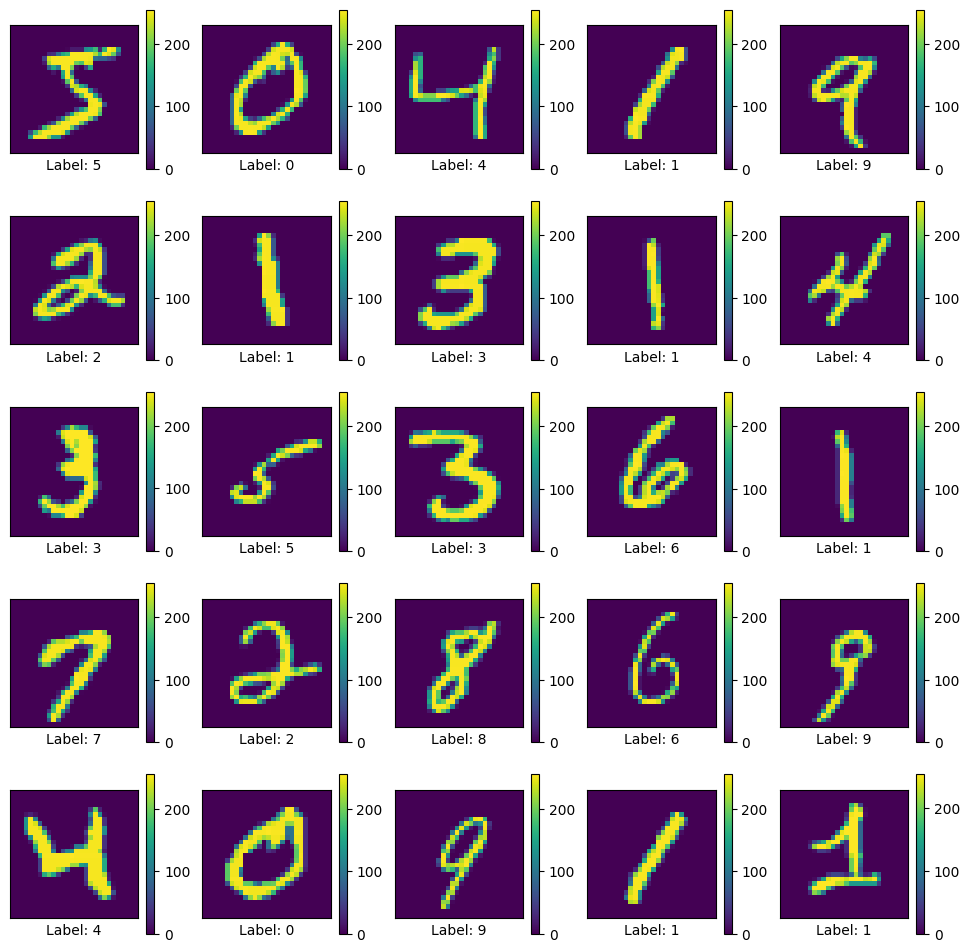

In [5]:
mostrarImagenes(train_images, train_labels, rgb = True)

Transformar los label de cada imagen en un vector del 0 al 9 que contengan ceros y solo exista un 1 indicando su posicion

In [6]:
translation_dict = {
    '0':[1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
    '1':[0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,],
    '2':[0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,],
    '3':[0.,0.,0.,1.,0.,0.,0.,0.,0.,0.,],
    '4':[0.,0.,0.,0.,1.,0.,0.,0.,0.,0.,],
    '5':[0.,0.,0.,0.,0.,1.,0.,0.,0.,0.,],
    '6':[0.,0.,0.,0.,0.,0.,1.,0.,0.,0.,],
    '7':[0.,0.,0.,0.,0.,0.,0.,1.,0.,0.,],
    '8':[0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,],
    '9':[0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,],
    '0':[0.,0.,0.,0.,0.,0.,0.,0.,0.,1.,]
}
y_train = np.empty((train_labels.shape[0], 10), dtype=np.float32)
i = 0
for number in train_labels:
    y_train[i]=translation_dict[str(number)]
    i+=1

y_test = np.empty((test_labels.shape[0], 10), dtype=np.float32)
i = 0
for number in test_labels:
    y_test[i]=translation_dict[str(number)]
    i+=1

Normalizar las imagenes convirtiendolos en una imagen con pixeles entre 0 y 1

In [7]:
train_images = train_images/255.0
test_images = test_images/255.0

Mostrar 25 primeros elementos del dataset de mnist normalizado reduciendo el espacio de color de 0 a 1

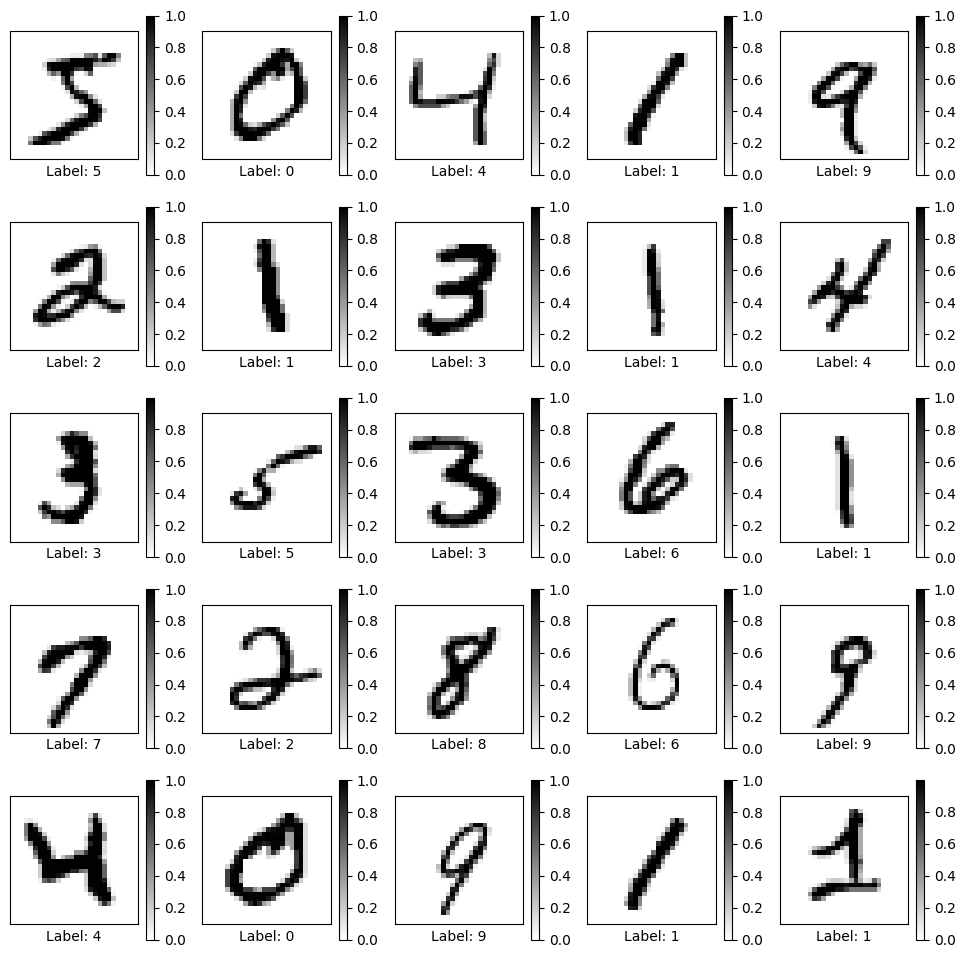

In [8]:
mostrarImagenes(train_images, train_labels, rgb=False)

Preparar las etiquetas de las imagenes para el entrenamiento

In [9]:
train_labels, test_labels = y_train, y_test

### Crear una RNN simple

In [10]:
from keras.utils import to_categorical
modelSimpleRNN = Sequential()
modelSimpleRNN.add(SimpleRNN(128,activation='relu', input_shape = (train_images.shape[1:]),return_sequences=True))
modelSimpleRNN.add(Dropout(0.2))
modelSimpleRNN.add(SimpleRNN(128,activation='relu'))
modelSimpleRNN.add(Dropout(0.2))
modelSimpleRNN.add(Dense(64,activation='relu'))
modelSimpleRNN.add(Dropout(0.2))
modelSimpleRNN.add(Dense(10,activation='softmax'))
modelSimpleRNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],)
modelSimpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 28, 128)           20096     
                                                                 
 dropout (Dropout)           (None, 28, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                6

Entrenar el modelo de RNN para 3 epocas

In [11]:
histSimpleRNN = modelSimpleRNN.fit(train_images, train_labels, epochs=3, batch_size=32, validation_data=(test_images,test_labels))

Epoch 1/3
1875/1875 [==============================] - 176s 91ms/step - loss: 0.4758 - accuracy: 0.8438 - val_loss: 0.2575 - val_accuracy: 0.9313
Epoch 2/3
1875/1875 [==============================] - 185s 99ms/step - loss: 0.1855 - accuracy: 0.9518 - val_loss: 0.1324 - val_accuracy: 0.9632
Epoch 3/3
1875/1875 [==============================] - 184s 98ms/step - loss: 0.1496 - accuracy: 0.9617 - val_loss: 0.1584 - val_accuracy: 0.9663


Mostrar grafico de precisión y el valor de precisión.

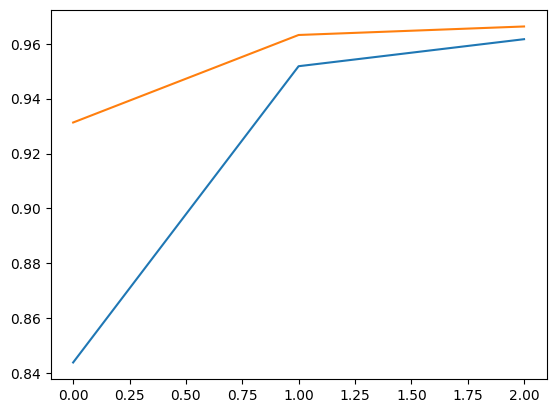

In [12]:
plt.plot(histSimpleRNN.history['accuracy'])
plt.plot(histSimpleRNN.history['val_accuracy'])
plt.show()

### Crear un modelo LSTM utilizando CuDNNLSTM

In [13]:
model_CuDNNLSTM = Sequential()
#No necesita funcion de activación ya que esta tiene la tangente hiperbolica dentro
model_CuDNNLSTM.add(CuDNNLSTM(128, input_shape = (train_images.shape[1:]),return_sequences=True))
model_CuDNNLSTM.add(Dropout(0.2))
model_CuDNNLSTM.add(CuDNNLSTM(128))
model_CuDNNLSTM.add(Dropout(0.2))
model_CuDNNLSTM.add(Dense(64,activation='relu'))
model_CuDNNLSTM.add(Dropout(0.2))
model_CuDNNLSTM.add(Dense(10,activation='softmax'))
model_CuDNNLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],)
model_CuDNNLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, 28, 128)           80896     
                                                                 
 dropout_3 (Dropout)         (None, 28, 128)           0         
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 128)               132096    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)               

Entrenar el modelo de LSTM para 3 epocas

In [14]:
hist_CuDNNLSTM = model_CuDNNLSTM.fit(train_images, train_labels, epochs=3, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/3
1875/1875 [==============================] - 36s 16ms/step - loss: 0.3590 - accuracy: 0.8854 - val_loss: 0.1141 - val_accuracy: 0.9655
Epoch 2/3
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1088 - accuracy: 0.9690 - val_loss: 0.0848 - val_accuracy: 0.9756
Epoch 3/3
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0742 - accuracy: 0.9793 - val_loss: 0.0662 - val_accuracy: 0.9825


Mostrar grafico de precisión y el valor de precisión.

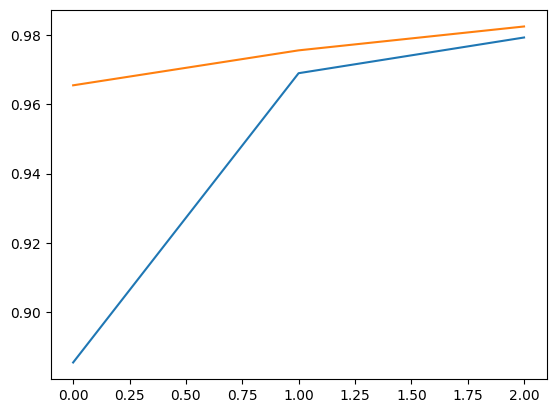

In [15]:
plt.plot(hist_CuDNNLSTM.history['accuracy'])
plt.plot(hist_CuDNNLSTM.history['val_accuracy'])
plt.show()

### Crear una red GRU utilizando CuDNNGRU

In [16]:
model_CuDNNGRU = Sequential()
#No necesita funcion de activación ya que esta tiene la tangente hiperbolica dentro
model_CuDNNGRU.add(CuDNNGRU(128, input_shape = (train_images.shape[1:]),return_sequences=True))
model_CuDNNGRU.add(Dropout(0.2))
model_CuDNNGRU.add(CuDNNGRU(128))
model_CuDNNGRU.add(Dropout(0.2))
model_CuDNNGRU.add(Dense(64,activation='relu'))
model_CuDNNGRU.add(Dropout(0.2))
model_CuDNNGRU.add(Dense(10,activation='softmax'))
model_CuDNNGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],)
model_CuDNNGRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnngru (CuDNNGRU)        (None, 28, 128)           60672     
                                                                 
 dropout_6 (Dropout)         (None, 28, 128)           0         
                                                                 
 cu_dnngru_1 (CuDNNGRU)      (None, 128)               99072     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)               

Entrenar el modelo de GRU para 3 epocas

In [17]:
hist_CuDNNGRU = model_CuDNNGRU.fit(train_images, train_labels, epochs=3, batch_size=32, validation_data=(test_images,test_labels))

Epoch 1/3
1875/1875 [==============================] - 30s 15ms/step - loss: 0.3573 - accuracy: 0.8838 - val_loss: 0.1044 - val_accuracy: 0.9676
Epoch 2/3
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0939 - accuracy: 0.9729 - val_loss: 0.0672 - val_accuracy: 0.9800
Epoch 3/3
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0664 - accuracy: 0.9817 - val_loss: 0.0435 - val_accuracy: 0.9873


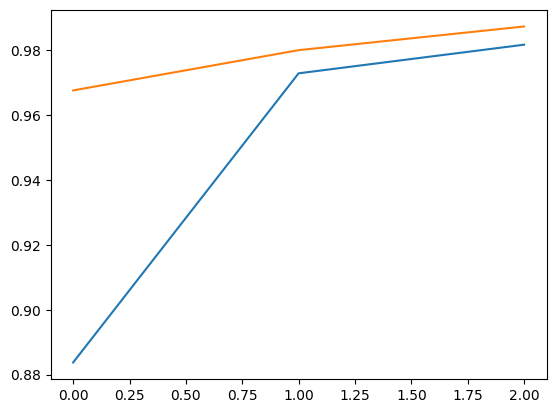

In [18]:
plt.plot(hist_CuDNNGRU.history['accuracy'])
plt.plot(hist_CuDNNGRU.history['val_accuracy'])
plt.show()

Evaluar con los modelos entrenados y mostrar su nivel de precision

In [19]:
print('Simple RNN')
test_loss, test_acc = modelSimpleRNN.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy:', test_acc)
print('\nLSTM')
test_loss, test_acc = model_CuDNNLSTM.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy:', test_acc)
print('\nGRU')
test_loss, test_acc = model_CuDNNGRU.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy:', test_acc)

Simple RNN
313/313 - 4s - loss: 0.1584 - accuracy: 0.9663 - 4s/epoch - 13ms/step
Test accuracy: 0.9663000106811523

LSTM
313/313 - 2s - loss: 0.0662 - accuracy: 0.9825 - 2s/epoch - 7ms/step
Test accuracy: 0.9825000166893005

GRU
313/313 - 2s - loss: 0.0435 - accuracy: 0.9873 - 2s/epoch - 6ms/step
Test accuracy: 0.9872999787330627


# Predicciones

Funciones para mostrar predicciones con imagenes

In [20]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def MostrarPredicciones(modeloPrediccion):
  num_rows = 5
  num_cols = 4
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, modeloPrediccion[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, modeloPrediccion[i], test_labels)
  plt.tight_layout()
  plt.show()

Realizar la prediccion con los datos de test

In [21]:
predictionsSimpleRNN = modelSimpleRNN.predict(test_images)
predictionsLSTM = model_CuDNNLSTM.predict(test_images)
predictionsGRU = model_CuDNNGRU.predict(test_images)

313/313 [==============================] - 2s 5ms/step


Convertir a un vector las etiquetas de los datos de test para predecir.

In [22]:
labels = []
for elemento in test_labels: labels.append(np.where(elemento == 1)[0][0])
test_labels = labels

Predecir una imagen en especifico del conjunto de imagenes de test, en el siguiente ejemplo se utilizó el dato numnero 1568.

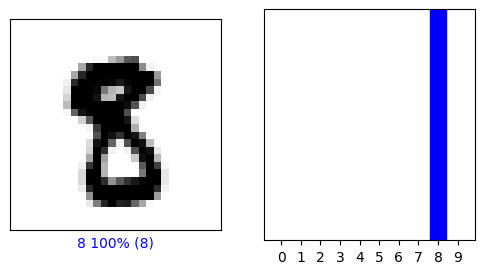

In [23]:
i = 1568
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictionsSimpleRNN[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictionsSimpleRNN[i],  test_labels)
plt.show()

Mostrar las 20 primeras predicciones del modelo **RNN Simple**.

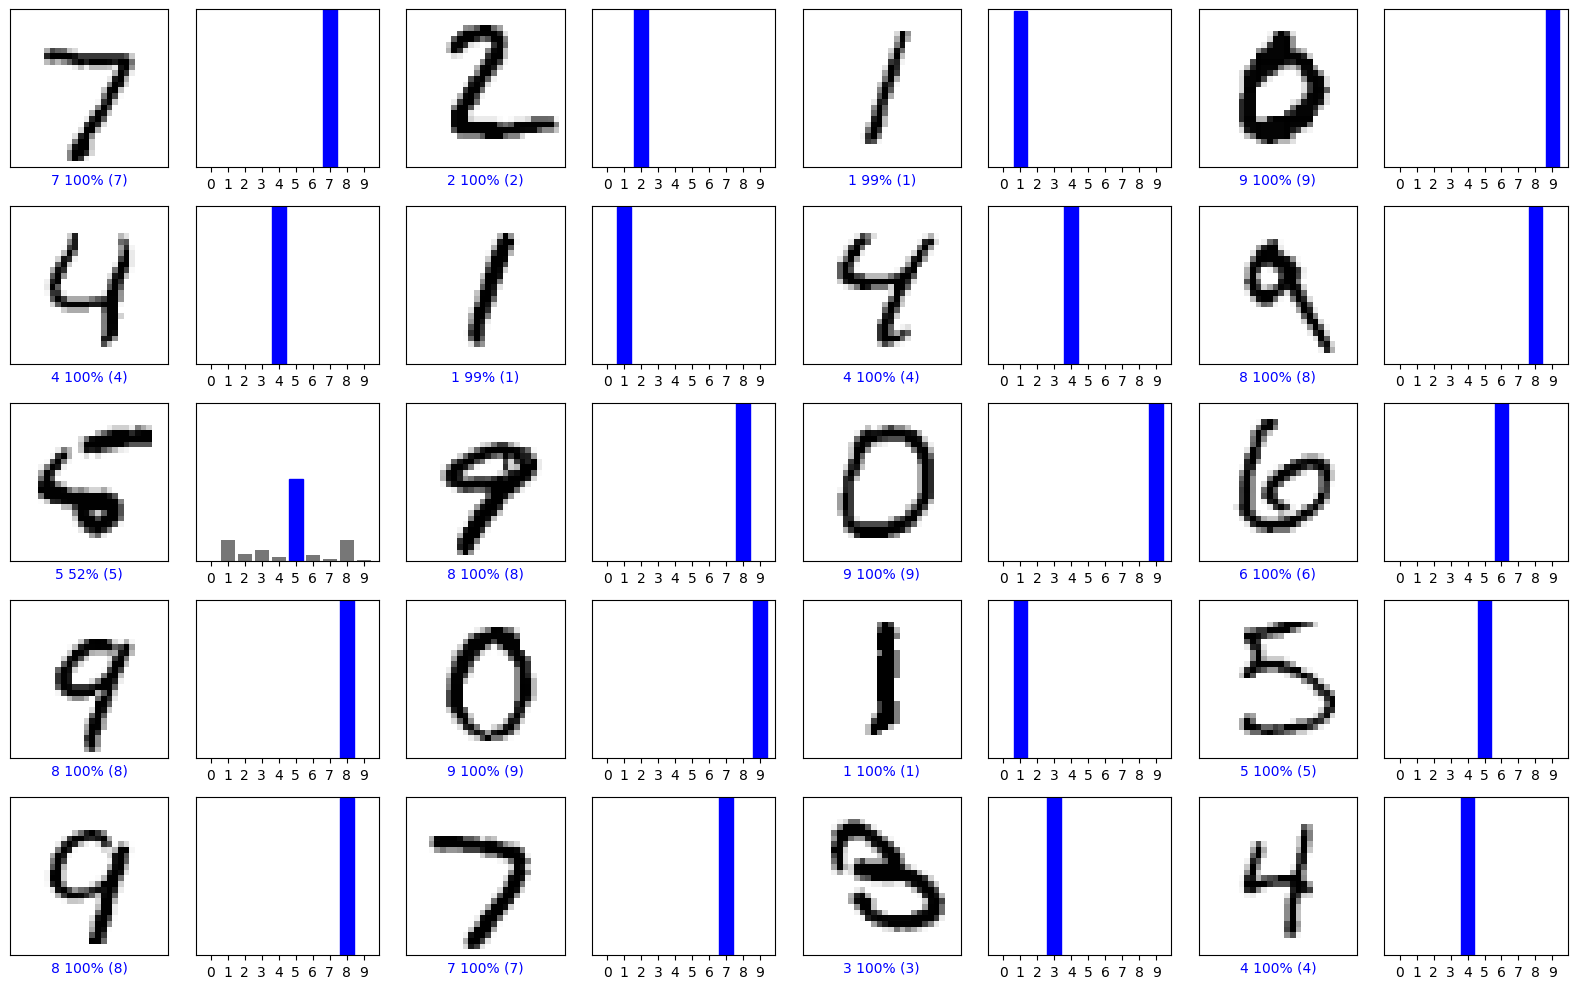

In [24]:
MostrarPredicciones(predictionsSimpleRNN)

Mostrar las 20 primeras predicciones del modelo **LSTM**.

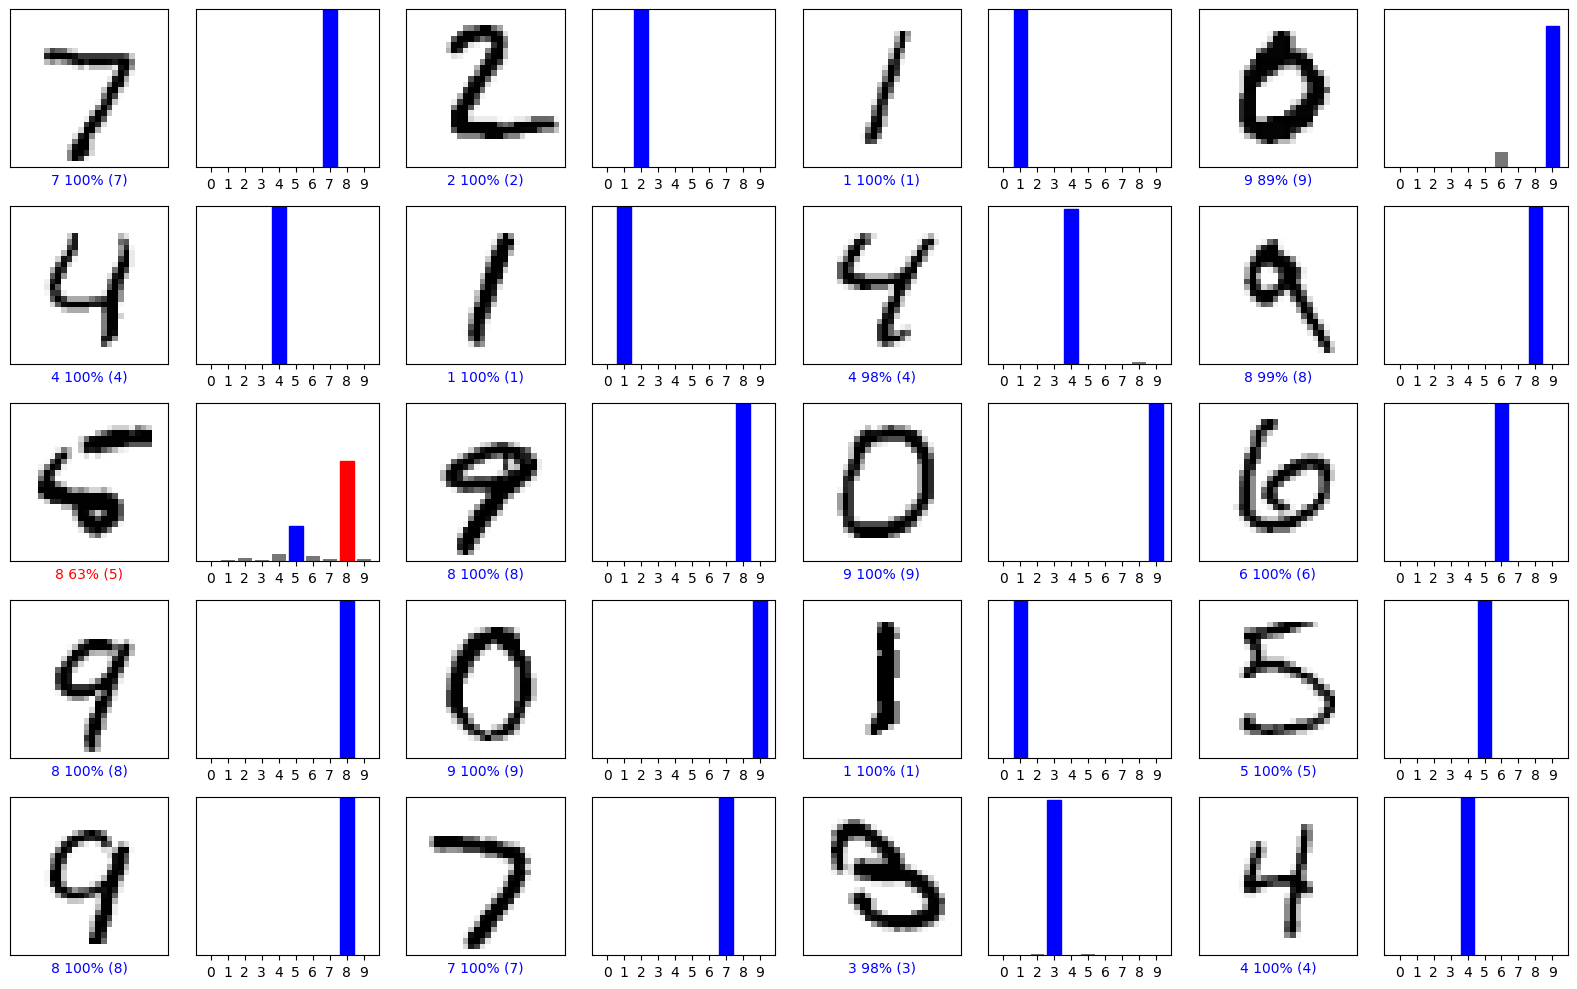

In [27]:
MostrarPredicciones(predictionsLSTM)

Mostrar las 20 primeras predicciones del modelo **GRU**.

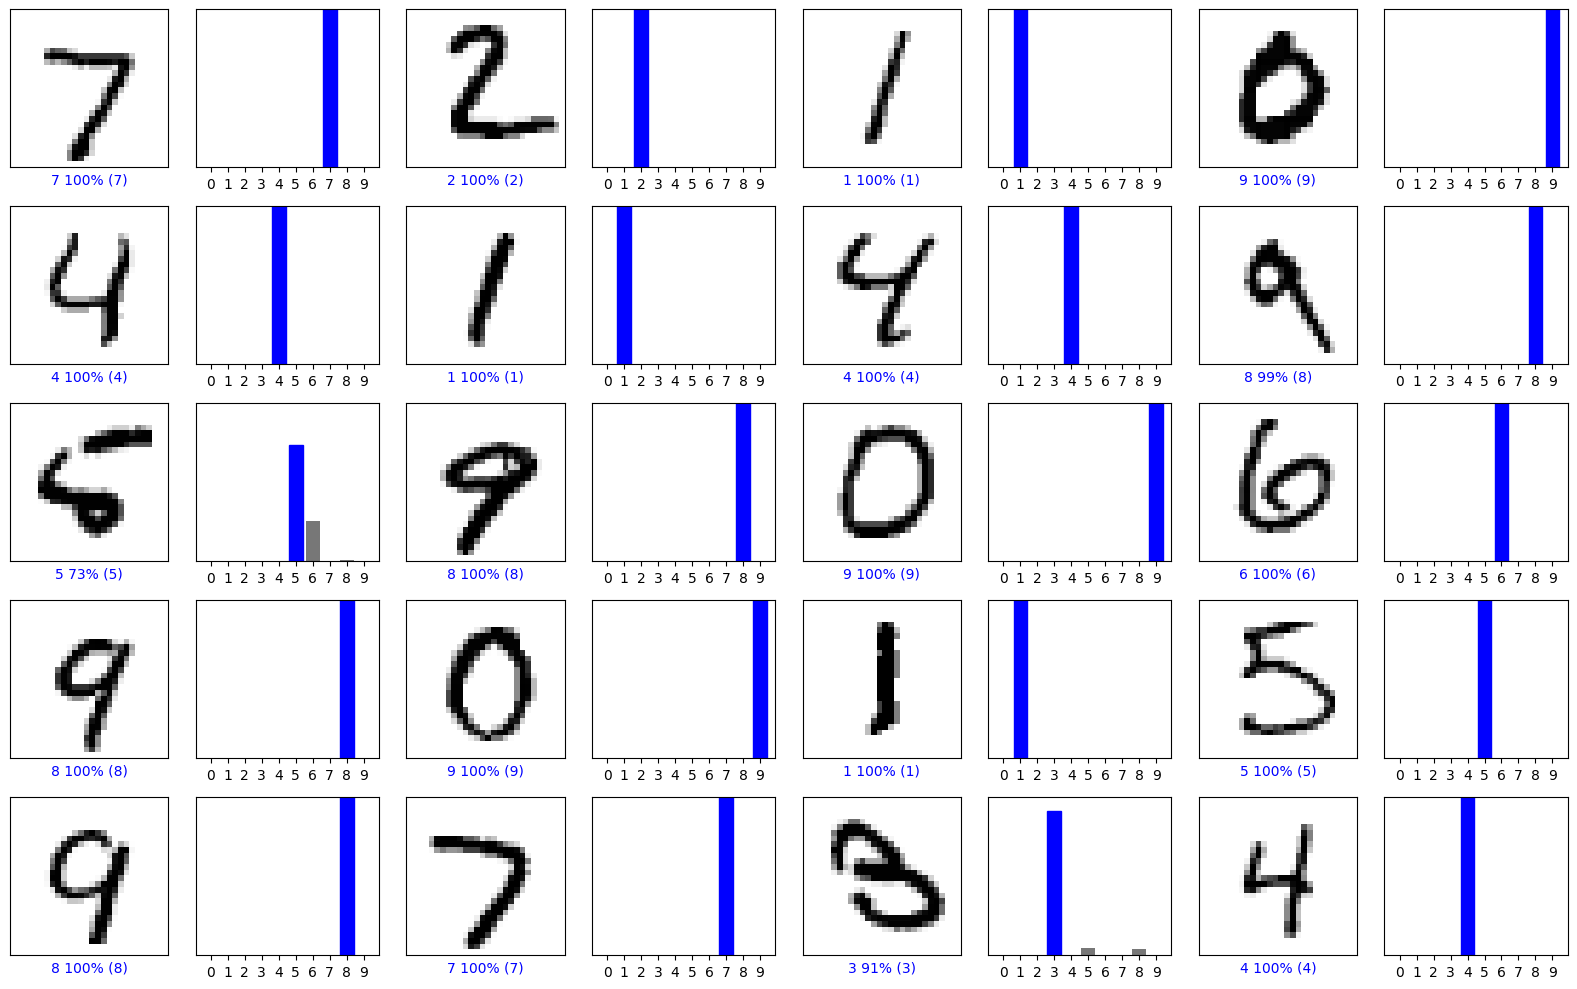

In [25]:
MostrarPredicciones(predictionsGRU)

Predicciones con datos externos

In [26]:
def binarizar(pixel):
    #Umbral 128
    if pixel < 128:
        return 0
    else:
        return 255
def predecir_imagen_externa(path_img):
    # Cargar imagen
    img = load_img(path_img, color_mode='rgb') #, target_size=(28,28))

    # Crear una figura con 1x5 subfiguras
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(18, 3))
    fig.subplots_adjust(hspace=0.4, top=0.80)
    fig.suptitle("Redes Neuronales Recurrentes", fontsize=15, color='red')

    #Mostrar la imagen de entrada
    im1 = axs[0].imshow(img)
    axs[0].set_title('Imagen Original')

    #Cambiar a tamaño 28 x 28 con antialiasing
    img = img.resize((28, 28), Image.Resampling.LANCZOS)

    #Invertir colores y convertir a escala de grises
    img = ImageOps.invert(img)
    img = ImageOps.grayscale(img)

    # Aplicar el filtro de binarización a la imagen y generar un desenfoque gausiano y reducir la gama de colores a 0-1
    img = img.point(binarizar)
    img = img.filter(ImageFilter.GaussianBlur(0.40))
    img_array = img_to_array(img)/255

    #Mostrar la imagen preprocesada
    axs[1].set_title('Imagen procesada')
    im2 = axs[1].imshow(img_array, cmap=plt.cm.binary)
    img_array = np.reshape(img_array, (1,28,28))

    # Hacer la predicción para RNN
    predictions = modelSimpleRNN.predict(np.transpose(img_array, (0, 1, 2)), verbose='none')
    predicted_class = np.argmax(predictions[0])
    axs[2].bar(class_names, predictions[0])
    axs[2].set_title(f'Predicción RNN Simple: {class_names[predicted_class]}')

    # Hacer la predicción para LSTM
    predictions = model_CuDNNLSTM.predict(np.transpose(img_array, (0, 1, 2)), verbose='none')
    predicted_class = np.argmax(predictions[0])
    axs[3].bar(class_names, predictions[0])
    axs[3].set_title(f'Predicción LSTM: {class_names[predicted_class]}')

    # Hacer la predicción para GRU
    predictions = model_CuDNNGRU.predict(np.transpose(img_array, (0, 1, 2)), verbose='none')
    predicted_class = np.argmax(predictions[0])
    axs[4].bar(class_names, predictions[0])
    axs[4].set_title(f'Predicción GRU: {class_names[predicted_class]}')

    # Agregar barra de color
    fig.colorbar(im1, ax=axs[0])
    fig.colorbar(im2, ax=axs[1])
    plt.show()

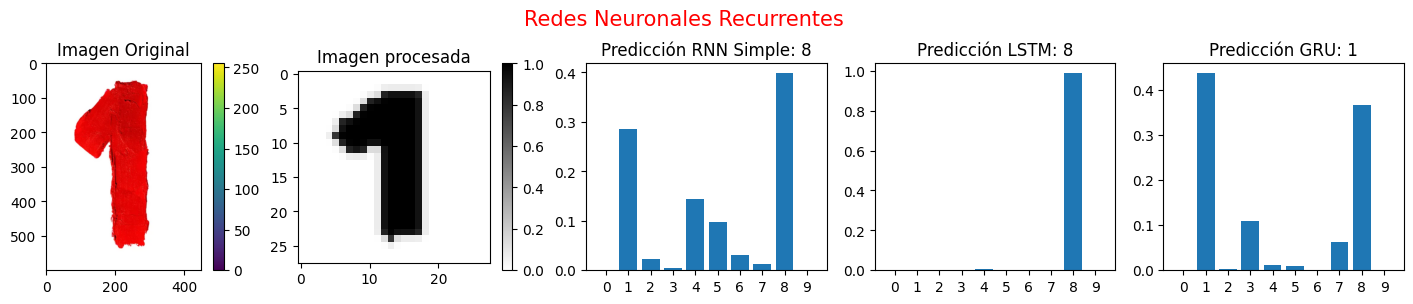

In [31]:
predecir_imagen_externa('../dataset/1.jpg')

Guardar modelos

In [ ]:
# modelSimpleRNN.save('content/model_SimpleRNN_MNIST.h5')
# model_CuDNNLSTM.save('content/model_LSTM_MNIST.h5')
# model_CuDNNGRU.save('content/model_LSTM_GRU.h5')